### Run a PCA on games played by the player and see if there is any pattern

1. Import data and add interesting features
2. Run PCA and analyze results

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', 250)

In [3]:
game_df = pd.read_pickle('./data/full_games_history.pkl')

In [ ]:
# game_df.head()

In [33]:
print(game_df.columns)

# Keep only useful columns: Could be nice to add : 
#   - the time between player's moves
# features = ['url', 'pgn', 'time_control', 'Moves', 'PlayerElo',
#             'OpponentElo', 'EloDiff', 'PlayerSide', 'TerminationStatus', 'TerminationType',
#             'PlayerAccuracie', 'OpponentAccuracie', 'AccuracieDiff', 'Opening']

features = ['PlayerElo', 'OpponentElo', 'EloDiff', 'PlayerAccuracie', 'OpponentAccuracie', 'AccuracieDiff']


Index(['url', 'pgn', 'time_control', 'end_time', 'rated', 'tcn', 'uuid',
       'initial_setup', 'fen', 'time_class', 'rules', 'start_time',
       'player_profile', 'white_accuracie', 'black_accuracie', 'Event', 'Site',
       'Date', 'Round', 'White', 'Black', 'Result', 'CurrentPosition',
       'Timezone', 'ECO', 'ECOUrl', 'UTCDate', 'UTCTime', 'WhiteElo',
       'BlackElo', 'TimeControl', 'Termination', 'StartTime', 'EndDate',
       'EndTime', 'Link', 'Moves', 'TerminationStatus', 'PlayerSide',
       'PlayerElo', 'OpponentElo', 'EloDiff', 'PlayerAccuracie',
       'OpponentAccuracie', 'AccuracieDiff', 'Duration', 'TerminationType',
       'Opening', 'AvgTimeWhite', 'AvgTimeBlack', 'StdTimeWhite',
       'StdTimeBlack', 'PlayerAvgTime', 'OpponentAvgTime', 'PlayerStdTime',
       'OpponentStdTime', 'AvgTimeDiff', 'StdTimeDiff'],
      dtype='object')


In [34]:
# Keep only game with an accuracie
df = game_df[features].loc[~game_df.AccuracieDiff.isna()].copy()
df.shape

(2387, 6)

In [35]:
target = game_df['TerminationStatus'].loc[~game_df.AccuracieDiff.isna()].reset_index(drop=True).copy()

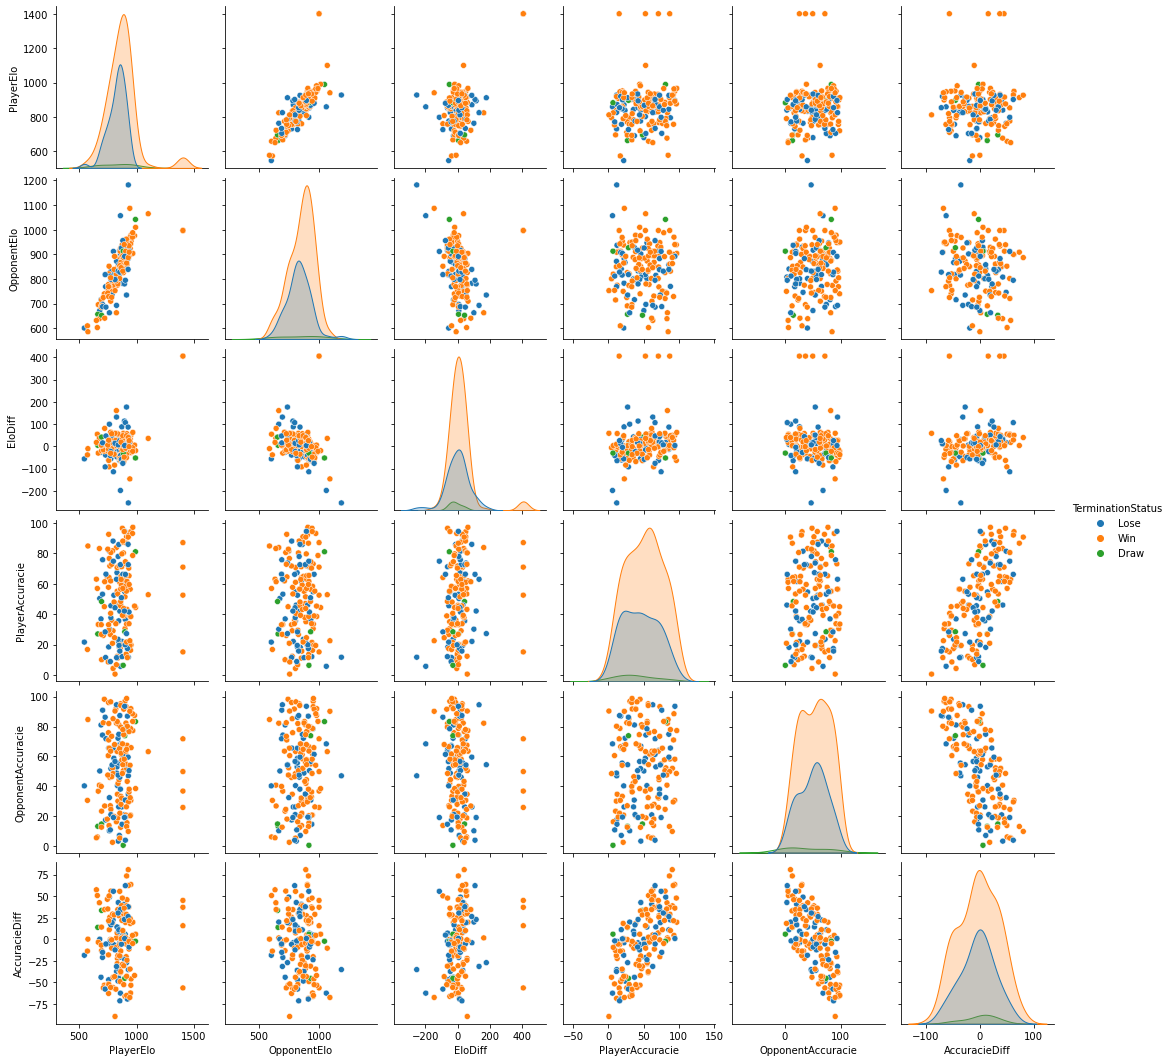

In [36]:
sns.pairplot(pd.concat([df, target], axis=1), hue='TerminationStatus')
plt.show()

In [37]:
# Scale data
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)
# scaled_data

In [38]:
# Compute PCA
pca = PCA(n_components=4)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

Total of explained variance: 100.00%
Detail of PCA components: 


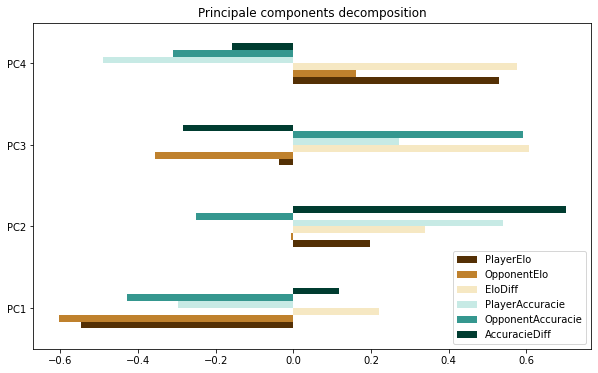

In [10]:
# Understand PCA results
print('Total of explained variance: {:.2f}%'.format(pca.explained_variance_ratio_.sum()*100))
print('Detail of PCA components: ')

pc_index = [f'PC{i+1}' for i, v in enumerate(pca.components_)]

comp_df = pd.DataFrame(pca.components_, columns=features)
comp_df.index = pc_index

comp_df.plot(kind='barh', colormap='BrBG', figsize=(10,6), title='Principale components decomposition')
plt.show()

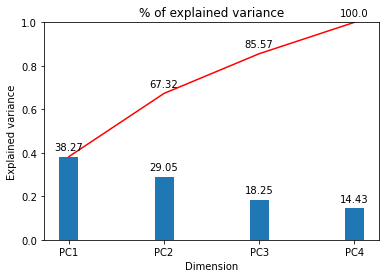

In [39]:
# Variance explained
plt.bar(pc_index,pca.explained_variance_ratio_, width=0.2)
plt.plot(pc_index, pca.explained_variance_ratio_.cumsum(), color='red')
plt.title('% of explained variance')
plt.xlabel('Dimension')
plt.ylabel('Explained variance')
plt.ylim(0,1)

# Plot values on the graph
for i,v in enumerate(pca.explained_variance_ratio_.cumsum()):
    plt.text(i, v+0.03, str(round(v*100,2)), ha="center")

for i,v in enumerate(pca.explained_variance_ratio_):
    if i != 0:
        plt.text(i, v+0.03, str(round(v*100,2)), ha="center")

plt.show()

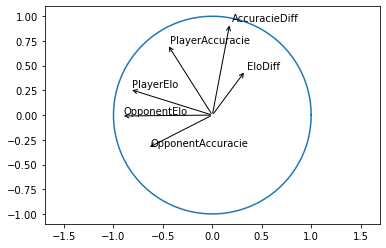

In [40]:
# Correlation circle between features and pca components
an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))
for i in range(scaled_data.shape[1]):
    x = np.corrcoef(x_pca[:,0], scaled_data[:,i])[0, 1]
    y = np.corrcoef(x_pca[:,1], scaled_data[:,i])[0, 1]
    plt.annotate('', xy = (x, y), xytext = (0,0), arrowprops = {'arrowstyle': '->'})
    plt.annotate(features[i], xy = (x + 0.02, y + 0.02))
plt.axis('equal')
plt.show()

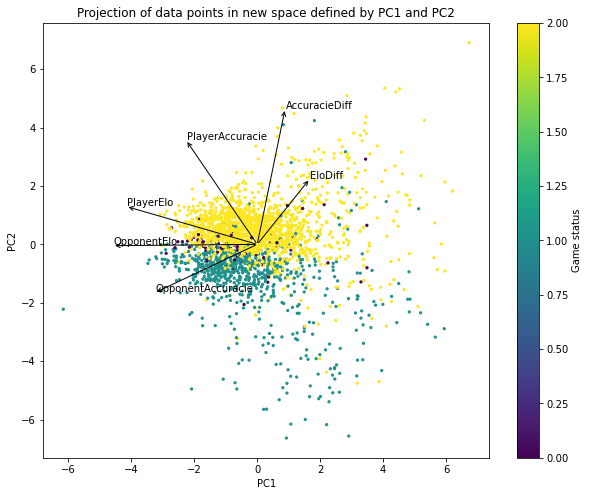

In [41]:
# Plot data points in the new space defined by PC1 and PC2

t = target.astype('category').cat.codes

plt.figure(figsize=(10,8))
plt.scatter(x_pca[:,0], x_pca[:,1], c=t, s=5)
cbar = plt.colorbar()
cbar.set_label('Game status')
plt.title('Projection of data points in new space defined by PC1 and PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')

scale_factor = 5
for i in range(scaled_data.shape[1]):
    x = np.corrcoef(x_pca[:,0], scaled_data[:,i])[0, 1]*scale_factor
    y = np.corrcoef(x_pca[:,1], scaled_data[:,i])[0, 1]*scale_factor
    plt.annotate('', xy = (x, y), xytext = (0,0), arrowprops = {'arrowstyle': '->'})
    plt.annotate(features[i], xy = (x + 0.02, y + 0.02))

plt.show()

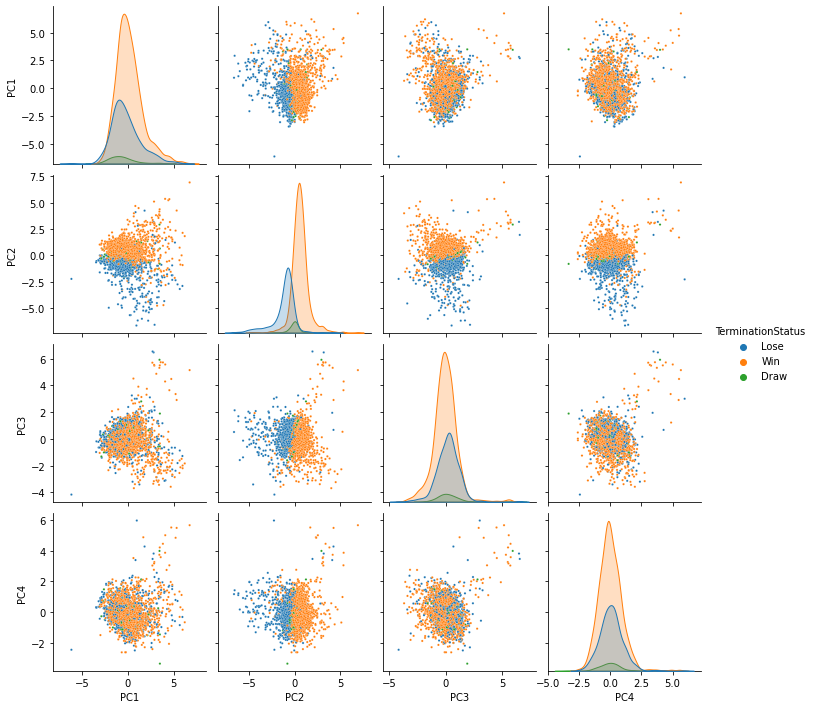

In [42]:
pc_df = pd.concat([pd.DataFrame(x_pca, columns=pc_index), target], axis=1)
sns.pairplot(pc_df, hue='TerminationStatus', plot_kws={"s": 5}) 
plt.show()

In [43]:
# Save PCA results
pc_df.to_pickle('./data/pca_results.pkl')

### Conclusion of PCA 

* Two first components (PC1 & PC2) encapsulate a good % of explained variance (67%)

* When projecting data points in the space Vect(PC1, PC2) it seems these data point separates in two clear groups along to PC2 : PC2+ = Win, PC2- = Lose, Draw will me more complex to categorize (very imbalanced dataset)

* PC2 is driven by AccuracieDiff (+), PlayersAccuracie (+) and EloDiff (+) : which means more the AccuracieDiff, PlayersAccuracie and EloDiff are high more likely the player is to Win the game. OpponentElo (- but ~0) plays almost no role in PC2 and OpponentAccuracie (-) tends to limit PC2    